In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression #, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression #, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
RSEED=826

In [24]:
df = pd.read_csv('data/data.csv')
df.shape

(30557, 82)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [26]:
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for col in df.columns:
    if 'angle' in col or 'amf' in col[-3:]:
        df.drop([col], axis=1, inplace=True)

drop_cols = ['L3_CH4_CH4_column_volume_mixing_ratio_dry_air', 'L3_CH4_aerosol_height', 'L3_CH4_aerosol_optical_depth']
df.drop(drop_cols, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 45 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Place_ID X Date                                  30557 non-null  object 
 1   Date                                             30557 non-null  object 
 2   Place_ID                                         30557 non-null  object 
 3   target                                           30557 non-null  float64
 4   target_min                                       30557 non-null  float64
 5   target_max                                       30557 non-null  float64
 6   target_variance                                  30557 non-null  float64
 7   target_count                                     30557 non-null  int64  
 8   precipitable_water_entire_atmosphere             30557 non-null  float64
 9   relative_humidity_2m_above_g

In [28]:
df = df[df['target'] < 500]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30552 entries, 0 to 30556
Data columns (total 45 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Place_ID X Date                                  30552 non-null  object 
 1   Date                                             30552 non-null  object 
 2   Place_ID                                         30552 non-null  object 
 3   target                                           30552 non-null  float64
 4   target_min                                       30552 non-null  float64
 5   target_max                                       30552 non-null  float64
 6   target_variance                                  30552 non-null  float64
 7   target_count                                     30552 non-null  int64  
 8   precipitable_water_entire_atmosphere             30552 non-null  float64
 9   relative_humidity_2m_above_ground

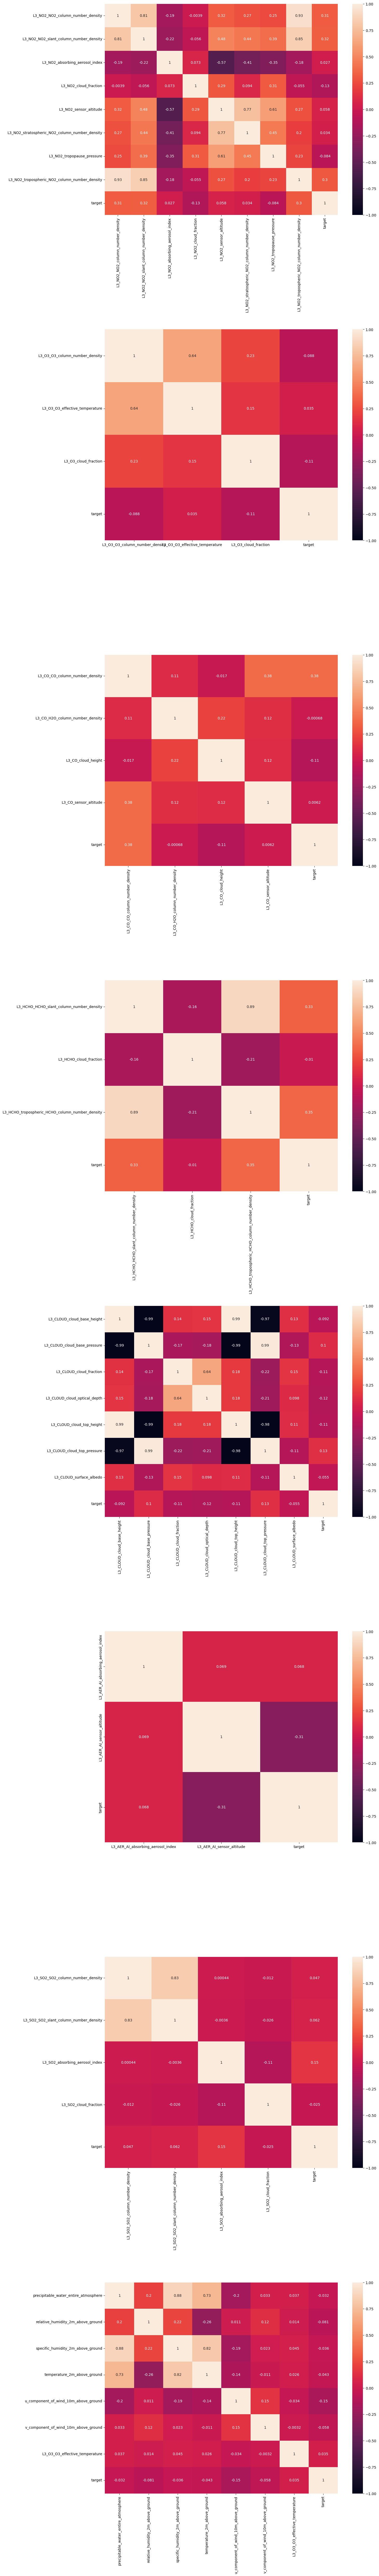

In [29]:
gases = ['NO2', 'O3', 'CO', 'HCHO', 'CLOUD', 'AER', 'SO2']

fig, axes = plt.subplots(len(gases)+1, 1, figsize=(16, 100))
axes = axes.flatten()

for ax, gas in zip(axes, gases):
    col_keeps = [col for col in df.columns if gas in col]
    corr_gas = df[col_keeps + ['target']]
    sns.heatmap(corr_gas.corr(), annot=True, ax=ax, vmin=-1, vmax=1)

weather = ['humidity', 'wind', 'water', 'temperature']

col_keeps = [col for col in df.columns for w in weather if w in col]
corr_weather = df[col_keeps + ['target']]
sns.heatmap(corr_weather.corr(), annot=True, ax=axes[-1], vmin=-1, vmax=1)

plt.tight_layout(pad = 3)

In [30]:
use = list(df.columns[8:]) + ['target']
corr_df = df[use].corr().abs()

upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

threshold = 0.7
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
print(f'Columns to drop [{len(to_drop)}]:', to_drop)

df.drop(to_drop, axis=1, inplace=True)
df.info()

Columns to drop [17]: ['specific_humidity_2m_above_ground', 'temperature_2m_above_ground', 'L3_NO2_NO2_slant_column_number_density', 'L3_NO2_stratospheric_NO2_column_number_density', 'L3_NO2_tropospheric_NO2_column_number_density', 'L3_O3_cloud_fraction', 'L3_CO_H2O_column_number_density', 'L3_CO_sensor_altitude', 'L3_HCHO_cloud_fraction', 'L3_HCHO_tropospheric_HCHO_column_number_density', 'L3_CLOUD_cloud_base_pressure', 'L3_CLOUD_cloud_fraction', 'L3_CLOUD_cloud_top_height', 'L3_CLOUD_cloud_top_pressure', 'L3_AER_AI_absorbing_aerosol_index', 'L3_SO2_SO2_slant_column_number_density', 'L3_SO2_cloud_fraction']
<class 'pandas.core.frame.DataFrame'>
Index: 30552 entries, 0 to 30556
Data columns (total 28 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Place_ID X Date                           30552 non-null  object 
 1   Date                                      30552 non-null  obje

In [31]:
df.duplicated().value_counts()

False    30552
Name: count, dtype: int64

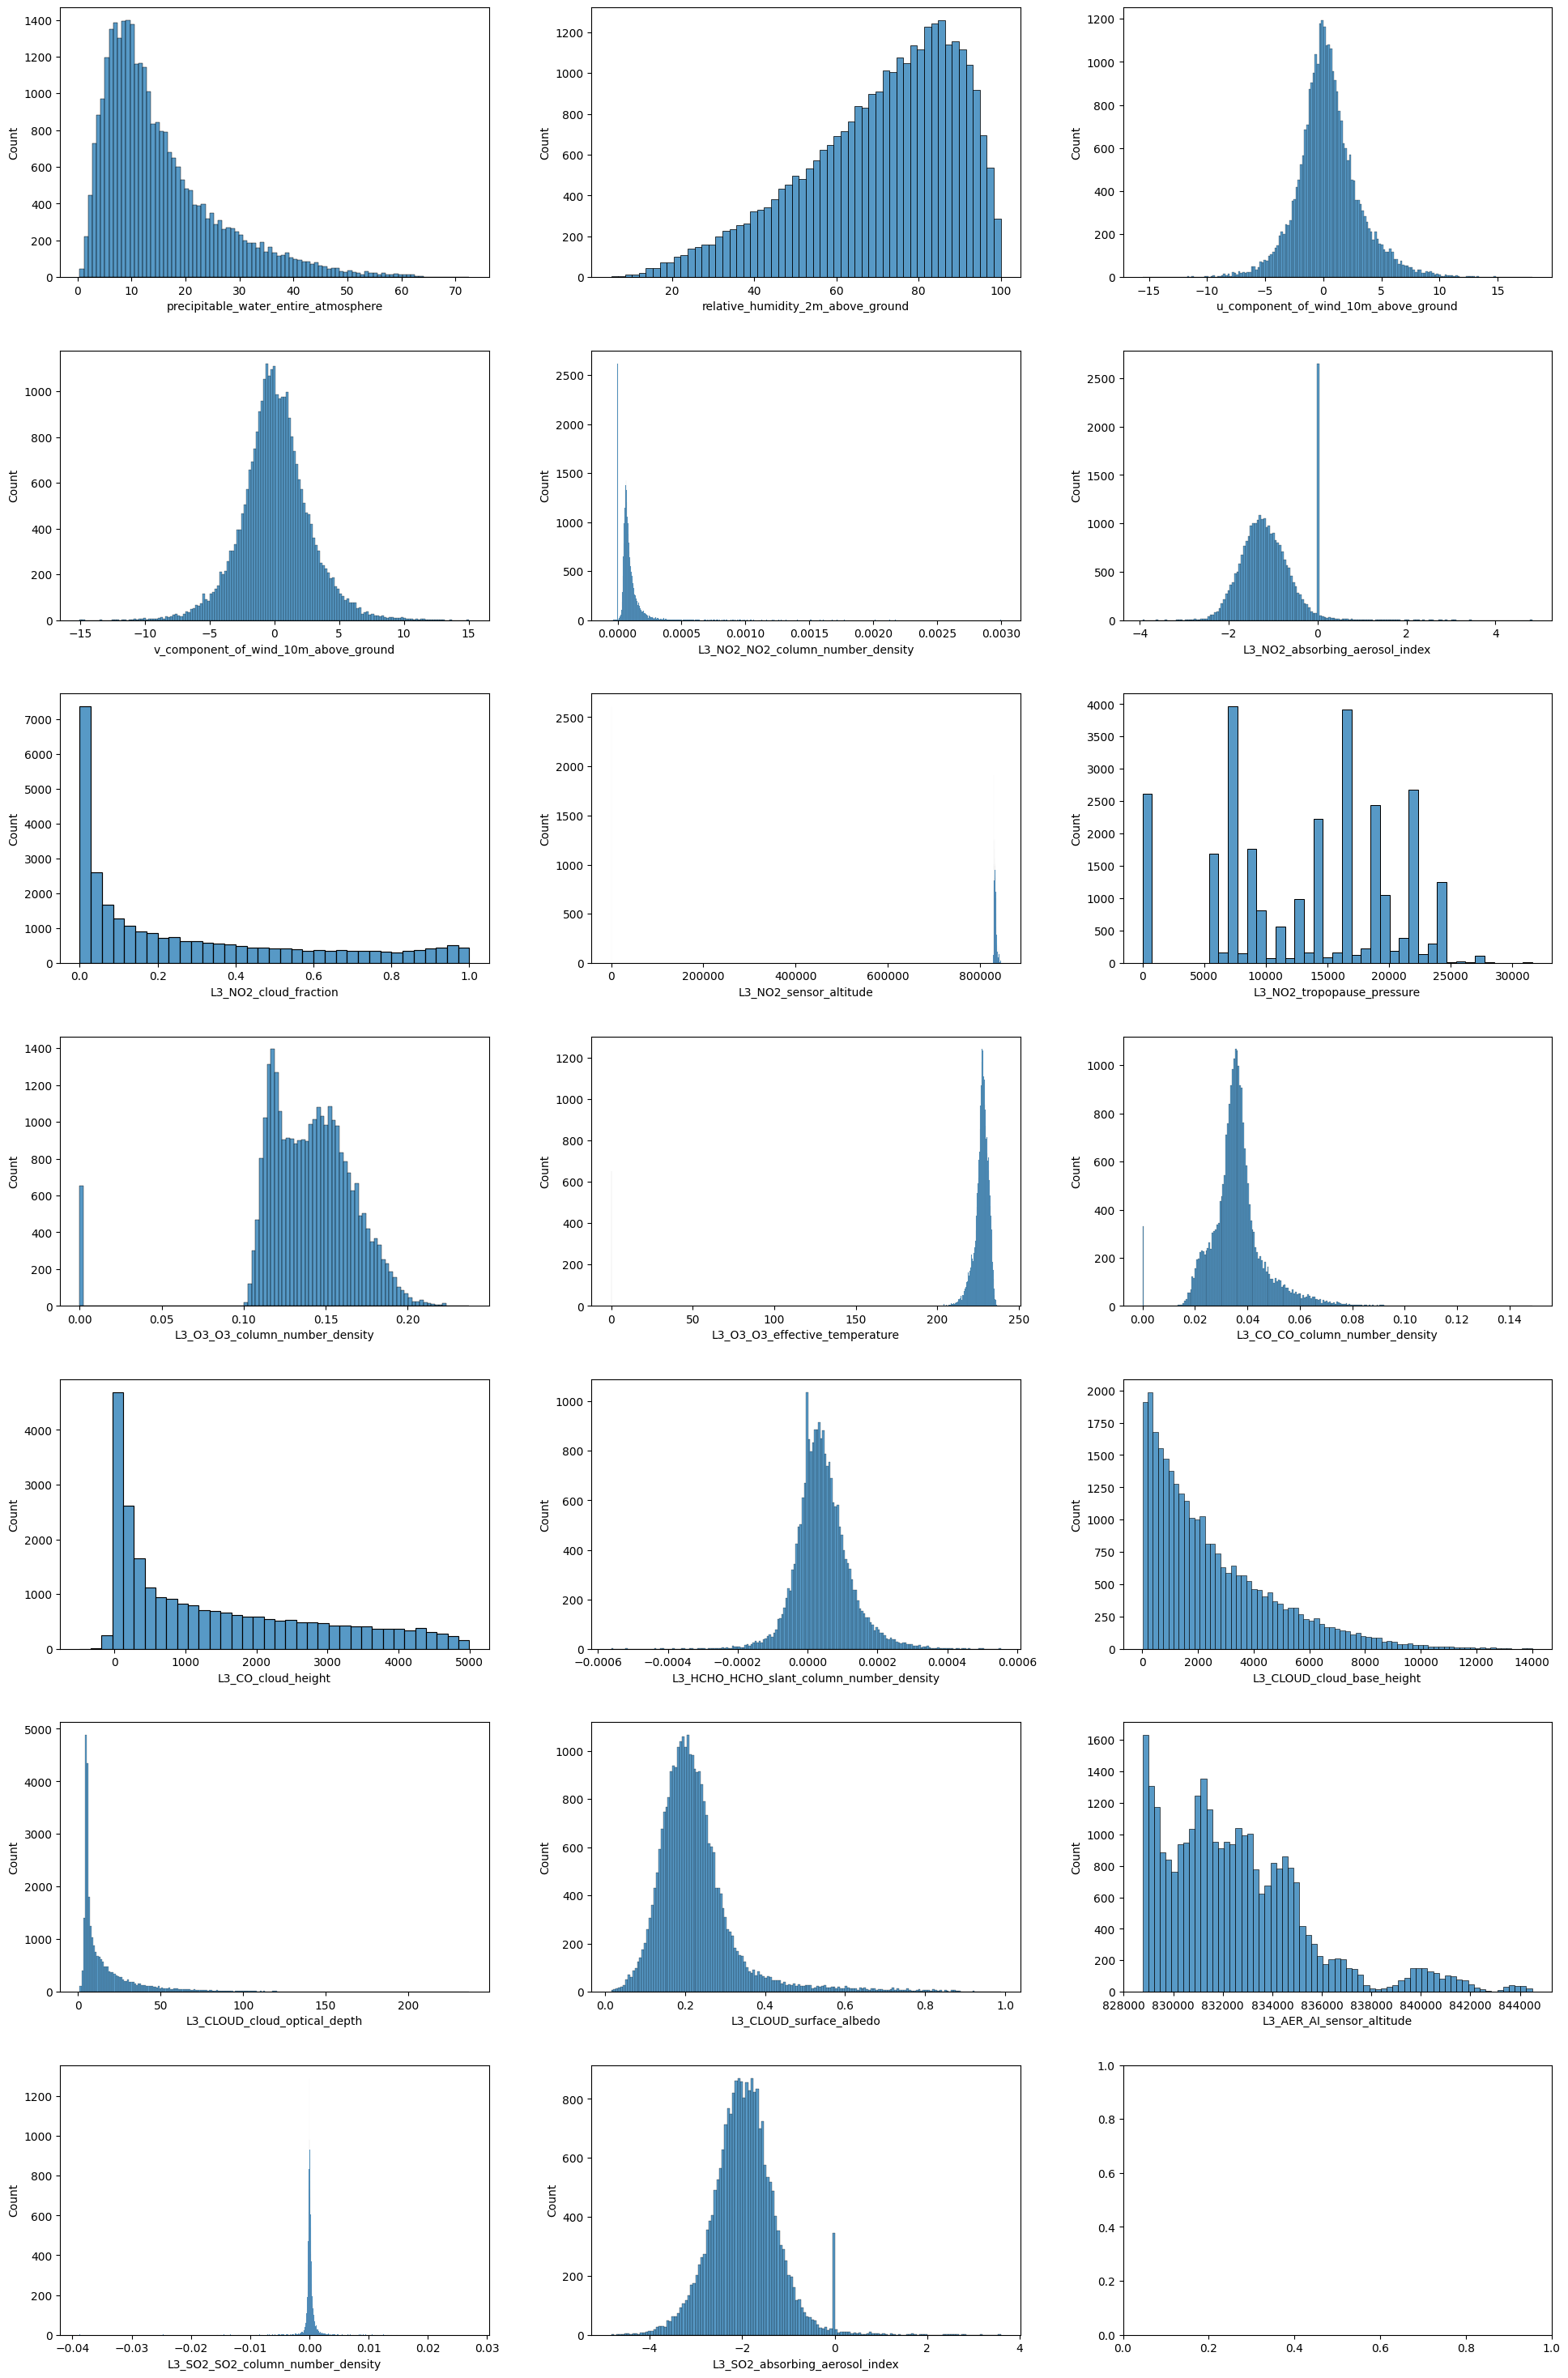

In [32]:
fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()

for ax, col in zip(axes, df.columns[8:]):
    sns.histplot(df, x=col, ax=ax)

plt.tight_layout(pad=3)

In [33]:
for col in ['target'] + list(df.columns[8:]):
    print(f'''{col}
min, mean, max:           {df[col].min().round(3)}   {df[col].mean().round(3)}   {df[col].max().round(3)}
quantiles (25, 50, 75):   {df[col].quantile(0.25).round(3)}   {df[col].quantile(0.50).round(3)}   {df[col].quantile(0.75).round(3)}\n''')

target
min, mean, max:           1.0   61.029   470.0
quantiles (25, 50, 75):   25.0   50.0   80.0

precipitable_water_entire_atmosphere
min, mean, max:           0.42   15.302   72.6
quantiles (25, 50, 75):   7.667   12.2   19.9

relative_humidity_2m_above_ground
min, mean, max:           5.129   70.56   100.0
quantiles (25, 50, 75):   58.612   74.1   85.455

u_component_of_wind_10m_above_ground
min, mean, max:           -15.56   0.417   17.955
quantiles (25, 50, 75):   -1.098   0.222   1.772

v_component_of_wind_10m_above_ground
min, mean, max:           -15.024   0.088   15.056
quantiles (25, 50, 75):   -1.416   0.012   1.554

L3_NO2_NO2_column_number_density
min, mean, max:           -0.0   0.0   0.003
quantiles (25, 50, 75):   0.0   0.0   0.0

L3_NO2_absorbing_aerosol_index
min, mean, max:           -3.942   -1.094   4.825
quantiles (25, 50, 75):   -1.515   -1.168   -0.743

L3_NO2_cloud_fraction
min, mean, max:           0.0   0.278   1.0
quantiles (25, 50, 75):   0.026   0.15   0

# Baseline Model

<Axes: xlabel='L3_CO_CO_column_number_density', ylabel='target'>

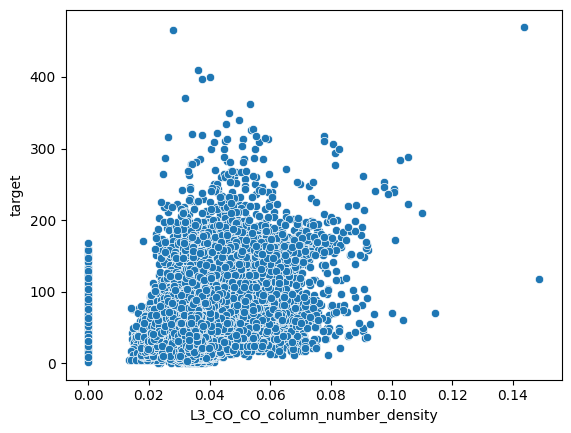

In [34]:
# baseline model based on strongest correlation to target: (?)
sns.scatterplot(df, x='L3_CO_CO_column_number_density', y='target')

In [36]:
X = df[['L3_CO_CO_column_number_density']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)
print(rmse)
print(r_squared)

43.06947700176252
0.1241052524164199


In [39]:
cols = ["precipitable_water_entire_atmosphere", "relative_humidity_2m_above_ground", "u_component_of_wind_10m_above_ground", "v_component_of_wind_10m_above_ground"]
#add clouds?

def baselinemodel(df, target_col, feature_cols=None):

    if feature_cols == None:
        feature_cols = df.select_dtypes(include='number').columns.drop(target_col)

    X = df[feature_cols]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluation
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print("Baseline Linear Regression Results")
    print(f"Features: {list(feature_cols)}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")

    return model, y_pred

model, preds = baselinemodel(df, target_col="target", feature_cols=cols)

Baseline Linear Regression Results
Features: ['precipitable_water_entire_atmosphere', 'relative_humidity_2m_above_ground', 'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground']
RMSE: 44.926
R²:   0.027


In [ ]:
peak_cols = [
    'L3_NO2_NO2_column_number_density',
    'L3_NO2_absorbing_aerosol_index',
    'L3_NO2_sensor_altitude',
    'L3_NO2_tropopause_pressure',
    'L3_O3_O3_column_number_density',
    'L3_O3_O3_effective_temperature',
    'L3_CO_CO_column_number_density'
    ]

df2 = df.copy()

df2[peak_cols] = df2[peak_cols].replace(0, np.nan)
df2[peak_cols] = df2[peak_cols].interpolate(method='polynomial', order=2)

fix, axes = plt.subplots(7, 3, figsize=(20, 30))
axes = axes.flatten()
for ax, col in zip(axes, df2.columns[8:]):
    sns.histplot(df2, x=col, ax=ax)
plt.tight_layout(pad=3)

# sns.scatterplot(df2, x='L3_NO2_absorbing_aerosol_index', y='target')

# Pipeline

In [40]:
y = df.pop("target")
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [41]:
df_train = pd.concat([X_train,y_train], axis=1)
df_test = pd.concat([X_test,y_test], axis=1)

df_train.shape, df_test.shape

((21386, 28), (9166, 28))

In [42]:
# drop target cols
# ["target" in col for col in num_cols.columns]
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [43]:
num_cols = X_train.select_dtypes("number").columns.tolist()
print(num_cols)
#X_train.select_dtypes("object").columns.tolist() #['Place_ID X Date', 'Date', 'Place_ID']

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', MinMaxScaler())
    ]), num_cols)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # Swap model here: Ridge(), Lasso(), RandomForestRegressor(), etc.
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

['target_min', 'target_max', 'target_variance', 'target_count', 'precipitable_water_entire_atmosphere', 'relative_humidity_2m_above_ground', 'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground', 'L3_NO2_NO2_column_number_density', 'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction', 'L3_NO2_sensor_altitude', 'L3_NO2_tropopause_pressure', 'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature', 'L3_CO_CO_column_number_density', 'L3_CO_cloud_height', 'L3_HCHO_HCHO_slant_column_number_density', 'L3_CLOUD_cloud_base_height', 'L3_CLOUD_cloud_optical_depth', 'L3_CLOUD_surface_albedo', 'L3_AER_AI_sensor_altitude', 'L3_SO2_SO2_column_number_density', 'L3_SO2_absorbing_aerosol_index']


In [44]:
# Evaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Baseline Linear Regression Results")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

Baseline Linear Regression Results
RMSE: 19.411
R²:   0.820
